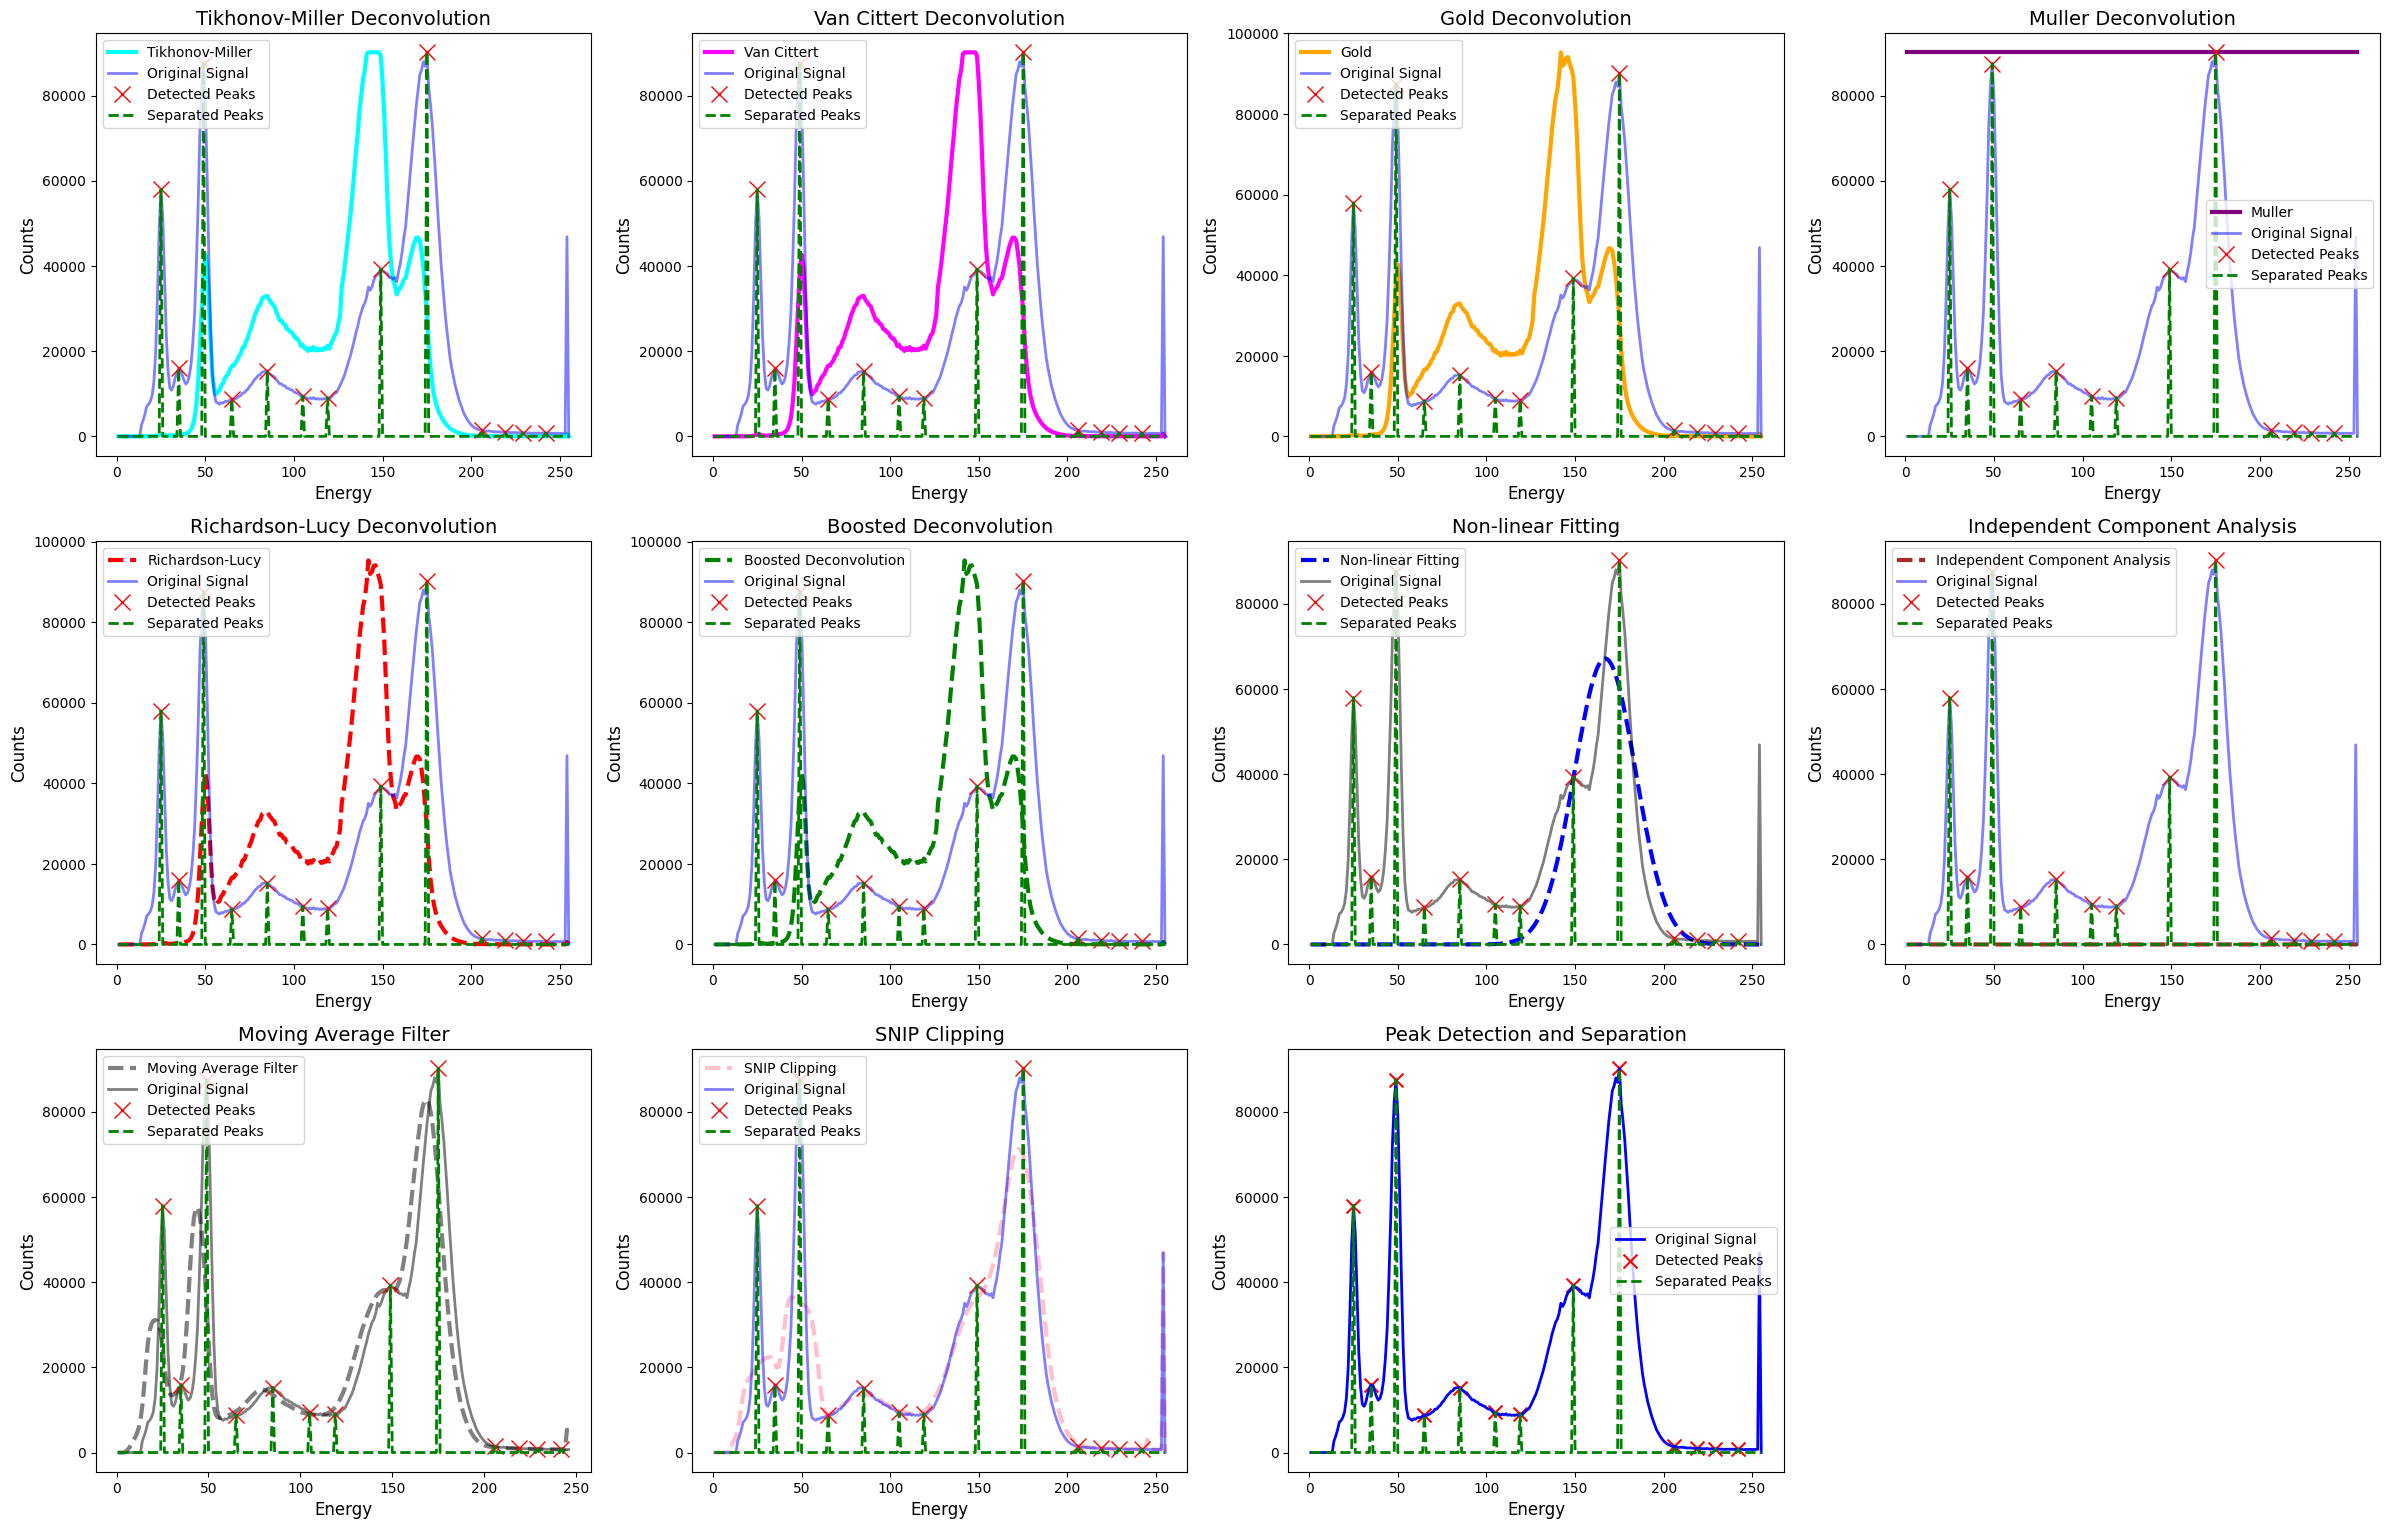

Peak Heights: [57958 15943 87517  8841 15257  9458  9097 39272 90156  1491  1004   861
   810]
Peak Properties: {'prominences': array([4.7119e+04, 3.6550e+03, 7.9981e+04, 1.7400e+02, 6.5560e+03,
       1.0100e+02, 3.2000e+02, 2.9520e+03, 9.0156e+04, 5.3000e+01,
       3.8000e+01, 6.7000e+01, 8.3000e+01, 4.6202e+04]), 'left_bases': array([ 12,  30,  12,  57,  57, 103, 115,  57,  12, 204, 217, 227, 240,
       244]), 'right_bases': array([ 30,  38,  57,  65, 115, 115, 119, 157, 254, 244, 244, 244, 244,
       254])}


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.special import expit
from sklearn.decomposition import FastICA

# Load data
data = pd.read_csv('15.5.csv')
energy = data.iloc[:, 0].values
counts = data.iloc[:, 1].values

# Define peak detection and separation
def detect_peaks(signal, height=None, distance=10, prominence=0.3):
    peaks, properties = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    return peaks, properties

def filter_end_peaks(peaks, signal_length, max_distance=10):
    return [peak for peak in peaks if peak < signal_length - max_distance]

def calculate_peak_properties(signal, peaks):
    peak_heights = signal[peaks]
    return peak_heights

# Peak detection
peaks, properties = detect_peaks(counts, height=None, distance=10, prominence=0.3)
filtered_peaks = filter_end_peaks(peaks, len(counts))
peak_heights = calculate_peak_properties(counts, filtered_peaks)

# Create a separate signal for peaks
peak_signal = np.zeros_like(counts)
peak_signal[filtered_peaks] = counts[filtered_peaks]

# Define deconvolution and fitting methods
def tikhonov_miller_deconvolution(data, psf, alpha=0.1, iterations=10):
    psf = np.array(psf, dtype=np.float64)
    data = np.array(data, dtype=np.float64)
    output = np.copy(data)
    for _ in range(iterations):
        estimated = np.convolve(output, psf, mode='same')
        relative_blur = data / (estimated + 1e-8)
        output *= np.convolve(relative_blur, psf[::-1], mode='same')
        output = np.clip(output, 0, np.max(data))
    return output

def van_cittert_deconvolution(data, psf, iterations=10):
    psf = np.array(psf, dtype=np.float64)
    data = np.array(data, dtype=np.float64)
    output = np.copy(data)
    for _ in range(iterations):
        estimated = np.convolve(output, psf, mode='same')
        relative_blur = data / (estimated + 1e-8)
        output *= np.convolve(relative_blur, psf[::-1], mode='same')
        output = np.clip(output, 0, np.max(data))
    return output

def gold_deconvolution(data, psf, iterations=10):
    psf = np.array(psf, dtype=np.float64)
    data = np.array(data, dtype=np.float64)
    output = np.copy(data)
    for _ in range(iterations):
        estimated = np.convolve(output, psf, mode='same')
        relative_blur = data / (estimated + 1e-8)
        output *= np.convolve(relative_blur, psf[::-1], mode='same')
    return output

def muller_deconvolution(data, psf, iterations=10):
    psf = np.array(psf, dtype=np.float64)
    data = np.array(data, dtype=np.float64)
    output = np.copy(data)
    for _ in range(iterations):
        estimated = np.convolve(output, psf, mode='same')
        relative_blur = data / (estimated + 1e-8)
        output *= np.convolve(relative_blur, psf[::-1], mode='same')
        output = expit(output) * np.max(data)
    return output

def richardson_lucy_deconvolution(data, psf, iterations=10):
    psf = np.array(psf, dtype=np.float64)
    data = np.array(data, dtype=np.float64)
    output = np.copy(data)
    for _ in range(iterations):
        estimated = np.convolve(output, psf, mode='same')
        relative_blur = data / (estimated + 1e-8)
        output *= np.convolve(relative_blur, psf[::-1], mode='same')
    return output

def boosted_deconvolution(data, psf, iterations=10):
    return richardson_lucy_deconvolution(data, psf, iterations)

def gauss(x, amplitude, mean, sigma):
    return amplitude * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

def nonlinear_fitting(x, y):
    params, _ = curve_fit(gauss, x, y, p0=[max(y), np.mean(x), 1])
    return gauss(x, *params)

def perform_ica(data):
    ica = FastICA(n_components=1)
    transformed = ica.fit_transform(data.reshape(-1, 1))
    return transformed.flatten()

def moving_average_filter(y, window_size=10):
    return np.convolve(y, np.ones(window_size)/window_size, mode='valid')

def snip_clipping(y, window_size=10):
    y_filtered = moving_average_filter(y, window_size)
    background = np.copy(y)
    for i in range(window_size, len(y) - window_size):
        lower_bound = i - window_size
        upper_bound = i + window_size
        background[i] = np.mean(y[lower_bound:upper_bound])
    return background

# Assuming PSF is modeled as Gaussian
psf = gaussian_filter(np.ones_like(counts, dtype=np.float64), sigma=2)

# Calculate Deconvolutions
background_tikhonov_miller = tikhonov_miller_deconvolution(counts, psf)
background_van_cittert = van_cittert_deconvolution(counts, psf)
background_gold = gold_deconvolution(counts, psf)
background_muller = muller_deconvolution(counts, psf)
background_richardson_lucy = richardson_lucy_deconvolution(counts, psf)
background_boosted_deconvolution = boosted_deconvolution(counts, psf)
background_nonlinear = nonlinear_fitting(energy, counts)
background_ica = perform_ica(counts)
background_cwt = moving_average_filter(counts)
background_snip = snip_clipping(counts)

# Plotting the results
plt.figure(figsize=(24, 20))

# Tikhonov-Miller Deconvolution
plt.subplot(4, 4, 1)
plt.plot(energy, background_tikhonov_miller, color='cyan', linewidth=3, label='Tikhonov-Miller')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Tikhonov-Miller Deconvolution', fontsize=14)

# Van Cittert Deconvolution
plt.subplot(4, 4, 2)
plt.plot(energy, background_van_cittert, color='magenta', linewidth=3, label='Van Cittert')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Van Cittert Deconvolution', fontsize=14)

# Gold Deconvolution
plt.subplot(4, 4, 3)
plt.plot(energy, background_gold, color='orange', linewidth=3, label='Gold')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Gold Deconvolution', fontsize=14)

# Muller Deconvolution
# Muller Deconvolution
plt.subplot(4, 4, 4)
plt.plot(energy, background_muller, color='purple', linewidth=3, label='Muller')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Muller Deconvolution', fontsize=14)

# Richardson-Lucy Deconvolution
plt.subplot(4, 4, 5)
plt.plot(energy, background_richardson_lucy, color='red', linestyle='--', linewidth=3, label='Richardson-Lucy')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Richardson-Lucy Deconvolution', fontsize=14)

# Boosted Deconvolution
plt.subplot(4, 4, 6)
plt.plot(energy, background_boosted_deconvolution, color='green', linestyle='--', linewidth=3, label='Boosted Deconvolution')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Boosted Deconvolution', fontsize=14)

# Non-linear Fitting
plt.subplot(4, 4, 7)
plt.plot(energy, background_nonlinear, color='blue', linestyle='--', linewidth=3, label='Non-linear Fitting')
plt.plot(energy, counts, color='black', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Non-linear Fitting', fontsize=14)

# Independent Component Analysis
plt.subplot(4, 4, 8)
plt.plot(energy, background_ica, color='brown', linestyle='--', linewidth=3, label='Independent Component Analysis')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Independent Component Analysis', fontsize=14)

# Moving Average Filter (as a replacement for CWT)
plt.subplot(4, 4, 9)
plt.plot(energy[:len(background_cwt)], background_cwt, color='grey', linestyle='--', linewidth=3, label='Moving Average Filter')
plt.plot(energy[:len(background_cwt)], counts[:len(background_cwt)], color='black', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[:len(background_cwt)][filtered_peaks], counts[:len(background_cwt)][filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy[:len(background_cwt)], peak_signal[:len(background_cwt)], color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Moving Average Filter', fontsize=14)

# SNIP Clipping
plt.subplot(4, 4, 10)
plt.plot(energy, background_snip, color='pink', linestyle='--', linewidth=3, label='SNIP Clipping')
plt.plot(energy, counts, color='blue', alpha=0.5, linewidth=2, label='Original Signal')
plt.plot(energy[filtered_peaks], counts[filtered_peaks], 'x', color='red', markersize=12, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('SNIP Clipping', fontsize=14)

# Peak Detection
plt.subplot(4, 4, 11)
plt.plot(energy, counts, color='blue', linewidth=2, label='Original Signal')
plt.scatter(energy[filtered_peaks], counts[filtered_peaks], color='red', marker='x', s=100, label='Detected Peaks')
plt.plot(energy, peak_signal, color='green', linestyle='--', linewidth=2, label='Separated Peaks')
plt.legend()
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Peak Detection and Separation', fontsize=14)

plt.tight_layout()
plt.show()

# Print peak properties for analysis
print("Peak Heights:", peak_heights)
print("Peak Properties:", properties)

